In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
def grad_U(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate), ai (the bias term for user), bj (bias 
    term for movie), mu (the average of Y)

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta * np.subtract(reg * Ui, (Yij - mu - np.dot(Ui, Vj) - ai - bj)* Vj)

def grad_V(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta * np.subtract(reg * Vj, (Yij - mu - np.dot(Ui, Vj) - ai - bj)* Ui)

def grad_a(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    return eta * (reg * ai - Yij + mu + np.dot(Ui, Vj) + ai + bj)

def grad_b(Yij, Ui, Vj, reg, eta, ai, bj, mu):
    return eta * (reg * bj - Yij + mu + np.dot(Ui, Vj) + ai + bj)

def get_err(Y, U, V, reg, a, b, mu):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T
    """
    sum = 0.0
    for x in range(len(Y)):
        i = Y[x, 0] - 1
        j = Y[x, 1] - 1
        Yij = Y[x, 2]
        sum += (Yij - mu - np.dot(U[i], V[j]) - a[i] - b[j])**2
    return reg / 2 * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2 + np.linalg.norm(a)**2 + np.linalg.norm(b)**2) + 0.5 * sum


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    a, b = -0.5, 0.5
    U = (b - a) * np.random.random_sample((M, K)) + a
    V = (b - a) * np.random.random_sample((N, K)) + a
    A = (b - a) * np.random.random_sample((M, 1)) + a # bias for user
    B = (b - a) * np.random.random_sample((N, 1)) + a # bias for movie
    mu = np.mean(Y[:, 2]) # average of all observed rating
    
    # first iteration, get loss reduction for initial epoch
    err0 = get_err(Y, U, V, reg, A, B, mu)
    arr = np.arange(len(Y))
    np.random.shuffle(arr)
    for index in arr:
        i = Y[index, 0] - 1
        j = Y[index, 1] - 1
        Yij = Y[index, 2]
        Ui, Vj, Ai, Bj = U[i], V[j], A[i], B[j]
        U[i] -= grad_U(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        V[j] -= grad_V(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        A[i] -= grad_a(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        B[j] -= grad_b(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
    err01 = err0 - get_err(Y, U, V, reg, A, B, mu)
    print(err01)

    # second through last iterations
    for epoch in range(max_epochs - 1):
        last_err = get_err(Y, U, V, reg, A, B, mu)
        arr = np.arange(len(Y))
        np.random.shuffle(arr)
        for index in arr:
            i = Y[index, 0] - 1
            j = Y[index, 1] - 1
            Yij = Y[index, 2]
            Ui, Vj, Ai, Bj = U[i], V[j], A[i], B[j]
            U[i] -= grad_U(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
            V[j] -= grad_V(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
            A[i] -= grad_a(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
            B[j] -= grad_b(Yij, Ui, Vj, reg, eta, Ai, Bj, mu)
        curr_err = get_err(Y, U, V, reg, A, B, mu)
        print('change in err / initial = ' + str((last_err - curr_err) / err01))
        if (last_err - curr_err) / err01 < eps:
            last_err = curr_err
            break
        last_err = curr_err
    return (U, V, A, B, last_err)

def clean_data(movies_file, data_file):
    unique_title_id_map = {}  # to keep track of titles that already have an id
    needed_updates = {}  # this array will map ids that need to be changed to the id
    # they should be changed to
    with open(movies_file, 'r') as f:
        for line in f:
            line_data = line.strip('\n').split('\t')
            movie_id, title = line_data[0], line_data[1]
            if str(title) in unique_title_id_map:
                needed_updates[movie_id] = unique_title_id_map[str(title)]
            else:
                unique_title_id_map[str(title)] = str(movie_id)
    # print(needed_updates)

    data_arr = np.loadtxt(data_file, dtype=np.int)
    for i, row in enumerate(data_arr):
        if str(row[1]) in needed_updates:
            data_arr[i, 1] = needed_updates[str(row[1])]
    return (data_arr)

In [3]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

#movie_cols = ['Movie ID','Movie Title', 'Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
#'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# data_arr = clean_data('data/movies.txt','data/data.txt')

#rat_cols = ['User ID', 'Movie ID', 'Rating']
#ratings = np.loadtxt('data/data.txt', names=rat_cols)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20

reg = 0.1
eta = 0.03 # learning rate

print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
U,V, A, B, e_in = train_model(M, N, k, eta, reg, Y_train)

Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
[33088.86821719]
change in err / initial = [0.06856374]
change in err / initial = [0.03776933]
change in err / initial = [0.04167022]
change in err / initial = [0.03542923]
change in err / initial = [0.0321057]
change in err / initial = [0.02891885]
change in err / initial = [0.02706461]
change in err / initial = [0.02471891]
change in err / initial = [0.02055572]
change in err / initial = [0.01829445]
change in err / initial = [0.01719727]
change in err / initial = [0.01410605]
change in err / initial = [0.0124749]
change in err / initial = [0.00968132]
change in err / initial = [0.01008422]
change in err / initial = [0.00843943]
change in err / initial = [0.00839012]
change in err / initial = [0.00536756]
change in err / initial = [0.00729997]
change in err / initial = [0.0053263]
change in err / initial = [0.00418326]
change in err / initial = [0.00512796]
change in err / initial = [0.00461881]
change in err / init

In [4]:
e_in /= len(Y_train)
e_out = get_err(Y_test, U, V, reg, A, B, np.mean(Y_test[:, 2]))/ len(Y_test)

In [5]:
print('E_in is ' + str(e_in))
print('E_out is ' + str(e_out))

E_in is [0.25850674]
E_out is [0.44094113]


In [6]:
movie_rating = np.zeros((1682, 1))
movie_num_user_rating = np.zeros((1682, 1))
for row in Y_train:
    # 0 is user id, 1 is movie id, 2 is rating
    movie_rating[row[1]-1] += row[2]
    movie_num_user_rating[row[1]-1] += 1
for row in Y_test:
    # 0 is user id, 1 is movie id, 2 is rating
    movie_rating[row[1]-1] += row[2]
    movie_num_user_rating[row[1]-1] += 1
movie_avg_rating = np.divide(np.array(movie_rating), np.array(movie_num_user_rating))

In [17]:
def visualize_2d(M):
    """Project a matrix into 2 dimensions and visualize it.

    If the input is mxn, produces a 2xn projection using the first two left singular vectors of M,
    and produces a scatterplot of the columns of this projection.

    If list index is provided, plots only the subset of columns indicated.

    If labels are provided, the indicated points are labeled in place on the graph (based on index
    matching between the labels list and the columns of the projection).

    If filename is provided, outputs the plot to the file indicated. Otherwise, outputs to the
    current matplotlib device.

    """
    A, sigma, B = np.linalg.svd(M)
    M_proj = np.matmul(A[:,:2].transpose(), M)
    
    cm = plt.cm.get_cmap('RdYlBu')
    #plt.close('all')
    #ax = plt.figure().gca()
    index = range(M.shape[1])
    #sc = plt.scatter(M_proj[0,index], M_proj[1,index], vmin=0,vmax=5, c=movie_avg_rating[index, 0], cmap=cm)
    sc = plt.scatter(M_proj[0,index], M_proj[1,index], s=3**2, vmin=0,vmax=5, c=movie_avg_rating[index, 0], cmap=cm)
    plt.colorbar(sc)
    
    plt.title("Bias Term V-Vector Visualization")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.savefig('basic.png')
    plt.show()
    plt.show()

    return M_proj

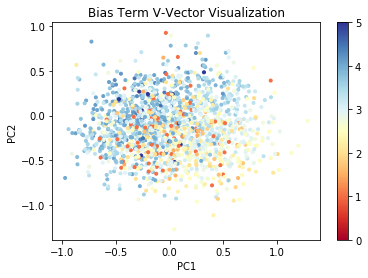

array([[ 0.21681709,  0.47552117,  0.05295427, ..., -0.21779612,
        -0.18241368,  0.26434457],
       [ 0.12262197, -0.04672225, -0.0262427 , ..., -0.84072534,
         0.43669643,  0.15898323]])

In [18]:
visualize_2d(V.T)

In [ ]:
visualize(U)